# Example usage of py-wsi

Author: @ysbecca


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import openslide
from openslide import open_slide  
from openslide.deepzoom import DeepZoomGenerator
from glob import glob

Set the path to the sample WSI to use here.

In [19]:
path = "/Users/ysbecca/ysbecca-projects/iciar-2018/data/WSI/04.svs"

In [20]:
plt.rcParams['figure.figsize'] = (10, 10)

Load the sample .svs file as an example.

In [21]:
files = glob(path)
files

['/Users/ysbecca/ysbecca-projects/iciar-2018/data/WSI/04.svs']

In [126]:
slide = open_slide(files[0]) 

In [170]:
tile_size = 256  
tiles = DeepZoomGenerator(slide, tile_size=tile_size, overlap=128, limit_bounds=True)
# overlap adds pixels to each side
# See how many tiles there are for each level of magnification.
print(tiles.level_count)
print(tiles.level_dimensions)
print(tiles.level_tiles)

17
((1, 1), (2, 2), (3, 3), (6, 6), (12, 12), (24, 23), (48, 45), (95, 89), (190, 177), (379, 354), (757, 708), (1514, 1415), (3027, 2829), (6053, 5657), (12105, 11313), (24209, 22625), (48417, 45249))
((1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (3, 3), (6, 6), (12, 12), (24, 23), (48, 45), (95, 89), (190, 177))


In [165]:
tiles.level_tiles[15]

(48, 45)

In [156]:
tile = tiles.get_tile(tiles.level_count - 2, (31, 31))  
tile_np = np.array(tile)
np.shape(tile_np)

(768, 768, 3)

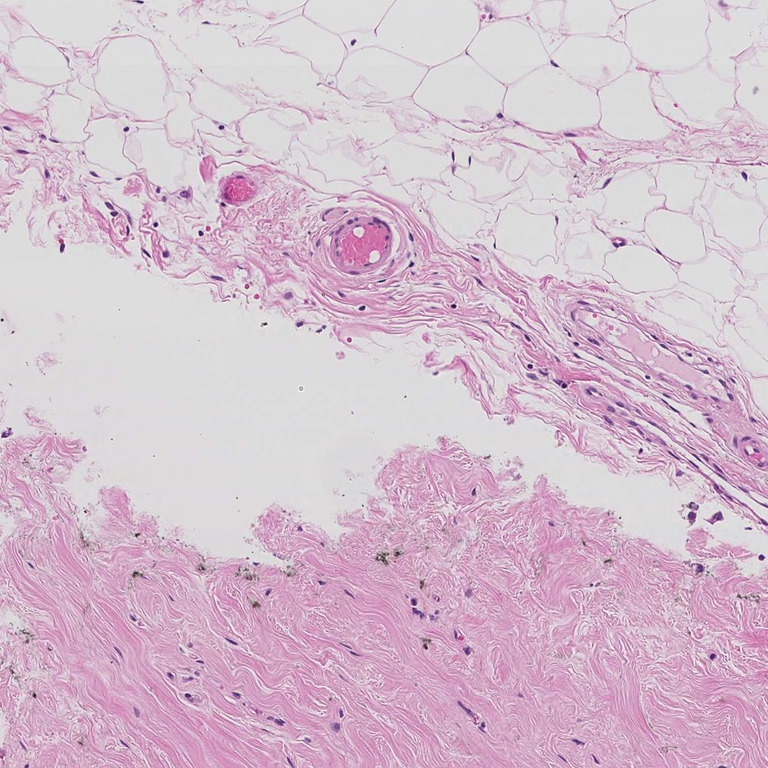

In [159]:
tile2 = tiles.get_tile(tiles.level_count - 2, (30, 31))
tile2

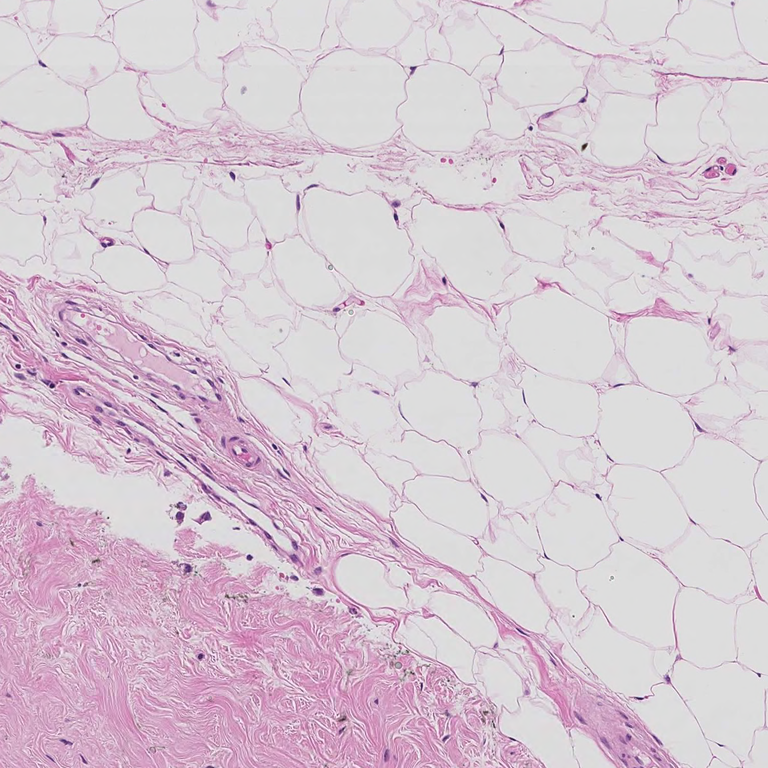

In [158]:
tile

In [54]:
slide.level_dimensions

((48417, 45249), (12104, 11312), (3026, 2828))

In [55]:
slide.level_downsamples

(1.0, 4.000085509506951, 16.000342038027803)

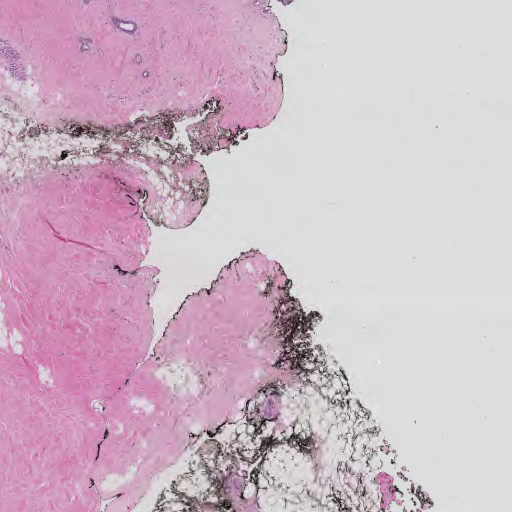

In [83]:
slide.read_region((40000, 30000), 2, (512,512))

In [169]:
slide.properties

<_PropertyMap {'aperio.AppMag': '20,000000', 'aperio.Date': '2013-12-13T10:30:01.53Z', 'aperio.Filename': 'ImageCollection_0000010170', 'aperio.MPP': '0,500000', 'aperio.OriginalHeight': '48417', 'aperio.OriginalWidth': '45249', 'openslide.comment': 'Aperio Image Library v12.4.0 \r\n48417x45249 (240x240) J2K/KDU Q=30;Leica SCN400;Leica SCN ver.1.5.0.10111 2011/09/07 12:35:23;1.5.0.10132|Filename = ImageCollection_0000010170|Date = 2013-12-13T10:30:01.53Z|AppMag = 20,000000|MPP = 0,500000|OriginalWidth = 45249|OriginalHeight = 48417', 'openslide.level-count': '3', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '45249', 'openslide.level[0].tile-height': '240', 'openslide.level[0].tile-width': '240', 'openslide.level[0].width': '48417', 'openslide.level[1].downsample': '4.0000855095069507', 'openslide.level[1].height': '11312', 'openslide.level[1].tile-height': '240', 'openslide.level[1].tile-width': '240', 'openslide.level[1].width': '12104', 'openslide.level[2].downs